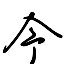

In [50]:
from PIL import Image, ImageFont, ImageDraw
import numpy as np

# image = Image.new('L', (64, 64))
image = Image.fromarray((np.zeros((64, 64)) + 255).astype('uint8'))
draw = ImageDraw.Draw(image)
font_block = ImageFont.truetype('Deng.ttf', 64)
font_cursive = ImageFont.truetype('xukeli.ttf', 64)
draw.text((0, 0), '今', font=font_cursive)
image

In [ ]:
import numpy as np
import tensorflow as tf
import random
from collections import deque
import dqn

import gym
from typing import List

import time

env = gym.make('CartPole-v0')
env._max_episode_steps = 10001
# env = gym.wrappers.Monitor(env, directory="gym-results/", force=True)

# Constants defining our neural network
INPUT_SIZE = env.observation_space.shape[0]
OUTPUT_SIZE = env.action_space.n

DISCOUNT_RATE = 0.99
REPLAY_MEMORY = 50000
BATCH_SIZE = 64
TARGET_UPDATE_FREQUENCY = 5
MAX_EPISODES = 5000


def replay_train(mainDQN: dqn.DQN, targetDQN: dqn.DQN, train_batch: list) -> float:
    """Trains `mainDQN` with target Q values given by `targetDQN`

    Args:
        mainDQN (dqn.DQN): Main DQN that will be trained
        targetDQN (dqn.DQN): Target DQN that will predict Q_target
        train_batch (list): Minibatch of replay memory
            Each element is (s, a, r, s', done)
            [(state, action, reward, next_state, done), ...]

    Returns:
        float: After updating `mainDQN`, it returns a `loss`
    """
    states = np.vstack([x[0] for x in train_batch])
    actions = np.array([x[1] for x in train_batch])
    rewards = np.array([x[2] for x in train_batch])
    next_states = np.vstack([x[3] for x in train_batch])
    done = np.array([x[4] for x in train_batch])

    X = states

    Q_target = rewards + DISCOUNT_RATE * np.max(targetDQN.predict(next_states), axis=1) * ~done

    y = mainDQN.predict(states)
    y[np.arange(len(X)), actions] = Q_target

    # Train our network using target and predicted Q values on each episode
    return mainDQN.update(X, y)


def get_copy_var_ops(*, dest_scope_name: str, src_scope_name: str) -> List[tf.Operation]:
    """Creates TF operations that copy weights from `src_scope` to `dest_scope`

    Args:
        dest_scope_name (str): Destination weights (copy to)
        src_scope_name (str): Source weight (copy from)

    Returns:
        List[tf.Operation]: Update operations are created and returned
    """
    # Copy variables src_scope to dest_scope
    op_holder = []

    src_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)

    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))

    return op_holder


def bot_play(mainDQN: dqn.DQN, env: gym.Env) -> None:
    """Test runs with rendering and prints the total score

    Args:
        mainDQN (dqn.DQN): DQN agent to run a test
        env (gym.Env): Gym Environment
    """
    state = env.reset()
    reward_sum = 0

    while True:

        # env.render()
        action = np.argmax(mainDQN.predict(state))
        state, reward, done, _ = env.step(action)
        reward_sum += reward

        if done:
            print("Total score: {}".format(reward_sum))
            break


def main():
    timestamp = time.time()
    
    # store the previous observations in replay memory
    replay_buffer = deque(maxlen=REPLAY_MEMORY)

    last_100_game_reward = deque(maxlen=100)

    with tf.Session() as sess:
        mainDQN = dqn.DQN(sess, INPUT_SIZE, OUTPUT_SIZE, name=f"main_{timestamp}")
        targetDQN = dqn.DQN(sess, INPUT_SIZE, OUTPUT_SIZE, name=f"target_{timestamp}")
        sess.run(tf.global_variables_initializer())

        # initial copy q_net -> target_net
        copy_ops = get_copy_var_ops(dest_scope_name=f"target_{timestamp}",
                                    src_scope_name=f"main_{timestamp}")
        sess.run(copy_ops)

        for episode in range(MAX_EPISODES):
            e = 1. / ((episode / 10) + 1)
            done = False
            step_count = 0
            state = env.reset()

            while not done:
                if np.random.rand() < e:
                    action = env.action_space.sample()
                else:
                    # Choose an action by greedily from the Q-network
                    action = np.argmax(mainDQN.predict(state))

                # Get new state and reward from environment
                next_state, reward, done, _ = env.step(action)

                if done:  # Penalty
                    reward = -1

                # Save the experience to our buffer
                replay_buffer.append((state, action, reward, next_state, done))

                if len(replay_buffer) > BATCH_SIZE:
                    minibatch = random.sample(replay_buffer, BATCH_SIZE)
                    loss, _ = replay_train(mainDQN, targetDQN, minibatch)

                if step_count % TARGET_UPDATE_FREQUENCY == 0:
                    sess.run(copy_ops)

                state = next_state
                step_count += 1

            print("Episode: {}  steps: {}".format(episode, step_count))

            # CartPole-v0 Game Clear Checking Logic
            last_100_game_reward.append(step_count)

            if len(last_100_game_reward) == last_100_game_reward.maxlen:
                avg_reward = np.mean(last_100_game_reward)

                if avg_reward > 199:
                    print(f"Game Cleared in {episode} episodes with avg reward {avg_reward}")
                    break


if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'tensorflow'